# Podcast Reviews Analysis

## Project Overview

The goal of this project is to perform an exploratory data analysis (EDA) on a dataset of podcast reviews. The dataset includes 2 million reviews for 100,000 podcasts. The data is stored in a SQLite database with four tables: `categories`, `podcasts`, `reviews`, and `runs`. 

## Data Loading and Preprocessing

We will use SQLite and Pandas to load the data and perform initial data cleaning and manipulation. This will include handling missing values, converting data types if necessary, and creating any new variables that might be useful for our analysis.

### EDA Questions

1. **Podcast Popularity and Ratings**
   - Which podcasts have the highest number of reviews?
   - How does the number of reviews correlate with the average rating of a podcast?
   - Is there a correlation between the length of a review and the rating it gives?

2. **Review Analysis**
   - What is the distribution of ratings across all reviews? Are there more positive or negative reviews?
   - Can we identify common sentiments in the review content? Are there certain words or phrases that appear more frequently in positive or negative reviews?

3. **Category Analysis**
   - What are the most common categories for podcasts? Are there certain categories that have more podcasts than others?
   - How does the distribution of ratings vary across the top 10 categories?

4. **Trends Over Time**
   - How have the number of reviews and average ratings changed over time?
   - Are there certain times of the year when more reviews are written or when ratings are particularly high or low?

5. **Author Analysis**
   - Are there authors who review more frequently than others? Do they tend to review certain types of podcasts or give certain types of ratings?

### Hypotheses

a. **Null Hypothesis (H0)**: There is no correlation between the length of a review and the rating it gives.

b. **Alternative Hypothesis (H1)**: There is a correlation between the length of a review and the rating it gives.

## Dashboard Creation

We will present our results in a dashboard created with a Looker. The dashboard will include at least three different types of charts and will be designed to clearly and effectively communicate our findings.

## Conclusion and Recommendations

We will conclude with a summary of our findings and any recommendations for further analysis or actions based on our results.

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import fasttext
from scipy import stats
import pandas as pd
import sqlite3 as sql
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from typing import Dict
from functions import *
import functions
import nltk
from nltk.corpus import stopwords
import string
import importlib
from textblob import TextBlob
from nltk import FreqDist
from collections import Counter

## Data Loading and Preprocessing

In [5]:
# Load data
conn = sql.connect('/Users/vytautas/Downloads/database.sqlite')

categories_df = load_data_from_sql('categories', conn)
podcasts_df = load_data_from_sql('podcasts', conn)
runs_df = load_data_from_sql('runs', conn)
reviews_df = load_data_from_sql('reviews', conn)

In [6]:
# Convert the 'created_at' and 'run_at' columns to datetime objects
reviews_df['created_at'] = pd.to_datetime(reviews_df['created_at'].apply(convert_arabic_numerals_to_english))
runs_df['run_at'] = pd.to_datetime(runs_df['run_at'].apply(convert_arabic_numerals_to_english))

### Categories DataFrame

In [7]:
analyze_dataframe(categories_df, "Categories")

Categories table:

Columns: ['podcast_id', 'category']

Summary statistics:
                              podcast_id         category
count                             212372           212372
unique                            110024              110
top     fa8c359031380cd4f3b38358c8a75f92  society-culture
freq                                   8            18710

Number of duplicates: 0

Number of missing values:
podcast_id    0
category      0
dtype: int64

First few rows:
                         podcast_id              category
0  c61aa81c9b929a66f0c1db6cbe5d8548                  arts
1  c61aa81c9b929a66f0c1db6cbe5d8548  arts-performing-arts
2  c61aa81c9b929a66f0c1db6cbe5d8548                 music
3  ad4f2bf69c72b8db75978423c25f379e                  arts
4  ad4f2bf69c72b8db75978423c25f379e           arts-design



- The table contains **212,372** rows and **2** columns: 'podcast_id' and 'category'.
- There are **110,024** unique podcasts and **110** unique categories.
- The most common category is 'society-culture', appearing **18,710** times.
- The podcast with ID 'fa8c359031380cd4f3b38358c8a75f92' appears most frequently, with **8** entries.
- There are **no** missing values or duplicate rows in the data.

### Podcasts DataFrame

In [8]:
analyze_dataframe(podcasts_df, "Podcasts")

Podcasts table:

Columns: ['podcast_id', 'itunes_id', 'slug', 'itunes_url', 'title']

Summary statistics:


          itunes_id
count  1.100240e+05
mean   1.309424e+09
std    3.575526e+08
min    7.332927e+07
25%    1.227235e+09
50%    1.467889e+09
75%    1.528936e+09
max    1.665764e+09

Number of duplicates: 0

Number of missing values:
podcast_id    0
itunes_id     0
slug          0
itunes_url    0
title         0
dtype: int64

First few rows:
                         podcast_id   itunes_id  \
0  a00018b54eb342567c94dacfb2a3e504  1313466221   
1  a00043d34e734b09246d17dc5d56f63c   158973461   
2  a0004b1ef445af9dc84dad1e7821b1e3   139076942   
3  a00071f9aaae9ac725c3a586701abf4d  1332508972   
4  a000a500f06555f81220c3eb641aded7  1544900779   

                                    slug  \
0                         scaling-global   
1  cornerstone-baptist-church-of-orlando   
2            mystery-dancing-in-the-dark   
3                      kts-money-matters   
4       word-on-the-street-w-dreak-swift   

                                          itunes_url  \
0  https://podcasts.apple.com/

- The table contains **110,024** rows and **5** columns: 'podcast_id', 'itunes_id', 'slug', 'itunes_url', and 'title'.
- There are **no** missing values or duplicate rows in the data.

In [9]:
# Clean the data
podcasts_df = remove_non_english(podcasts_df, ["title"])
podcasts_df = to_lowercase(podcasts_df, ["title"])
podcasts_df = remove_punctuation(podcasts_df, ["title"])
podcasts_df = remove_stopwords(podcasts_df, ["title"])

# Save the cleaned data to a new table in SQLite database
save_dataframe_to_sql(podcasts_df, conn, "podcasts_cleaned")
podcasts_cleaned_df = load_data_from_sql('podcasts_cleaned', conn)

1. **remove_non_english**: Removed rows from `podcasts_df` where the "title" column contained non-English content.
2. **to_lowercase**: Converted text in the "title" column of `podcasts_df` to lowercase.
3. **remove_punctuation**: Removed punctuation from the "title" column in `podcasts_df`.
4. **remove_stopwords**: Removed stopwords from the "title" column in `podcasts_df`.

### Runs DataFrame

In [10]:
analyze_dataframe(runs_df, "Runs") 

Runs table:

Columns: ['run_at', 'max_rowid', 'reviews_added']

Summary statistics:
                              run_at     max_rowid  reviews_added
count                             16  1.600000e+01   1.600000e+01
mean   2022-04-01 18:28:13.437499904  4.368318e+06   1.292206e+05
min              2021-05-10 02:53:00  3.266481e+06   0.000000e+00
25%              2021-08-25 17:59:03  3.382702e+06   1.281800e+04
50%              2022-06-14 05:59:54  4.167376e+06   1.908900e+04
75%    2022-09-13 17:05:22.249999872  5.330927e+06   3.799075e+04
max              2023-02-18 02:11:53  5.599789e+06   1.215223e+06
std                              NaN  9.678974e+05   3.194665e+05

Number of duplicates: 0

Number of missing values:
run_at           0
max_rowid        0
reviews_added    0
dtype: int64

First few rows:
               run_at  max_rowid  reviews_added
0 2021-05-10 02:53:00    3266481        1215223
1 2021-06-06 21:34:36    3300773          13139
2 2021-07-02 18:04:55    3329699       

- The table contains **16** rows and **3** columns: 'run_at', 'max_rowid', and 'reviews_added'.
- The 'max_rowid' column has a mean value of approximately **4,368,318**, with a standard deviation of **967,897**.
- The minimum 'max_rowid' is **3,266,481** and the maximum is **5,599,789**.
- The 'reviews_added' column has a mean value of approximately **129,220**, with a standard deviation of **319,466**.
- There are **no** missing values or duplicate rows in the data.

### Reviews DataFrame

In [11]:
analyze_dataframe(reviews_df, "Reviews")

Reviews table:

Columns: ['podcast_id', 'title', 'content', 'rating', 'author_id', 'created_at']

Summary statistics:
             rating
count  2.067529e+06
mean   4.627081e+00
std    1.045882e+00
min    1.000000e+00
25%    5.000000e+00
50%    5.000000e+00
75%    5.000000e+00
max    5.000000e+00

Number of duplicates: 655

Number of missing values:
podcast_id    0
title         0
content       0
rating        0
author_id     0
created_at    0
dtype: int64

First few rows:
                         podcast_id  \
0  c61aa81c9b929a66f0c1db6cbe5d8548   
1  c61aa81c9b929a66f0c1db6cbe5d8548   
2  ad4f2bf69c72b8db75978423c25f379e   
3  ad4f2bf69c72b8db75978423c25f379e   
4  ad4f2bf69c72b8db75978423c25f379e   

                                              title  \
0                               really interesting!   
1  Must listen for anyone interested in the arts!!!   
2                                 nauseatingly left   
3                                   Diverse stories   
4           

- The table contains **2,067,529** rows and **6** columns: 'podcast_id', 'title', 'content', 'rating', 'author_id', and 'created_at'.
- The 'rating' column has a mean value of approximately **4.63**, with a standard deviation of **1.05**.
- The minimum 'rating' is **1** and the maximum is **5**.
- There are **655** duplicate rows in the data.
- There are **no** missing values in the data. 

In [12]:
# Clean the data
reviews_df = remove_non_english(reviews_df, ["title", "content"])
reviews_df = to_lowercase(reviews_df, ["title", "content"])
reviews_df = remove_punctuation(reviews_df, ["title", "content"])
reviews_df = remove_stopwords(reviews_df, ["title", "content"])
reviews_df = add_length_column(reviews_df, "content", "content_length")

# Save the cleaned data to a new table in SQLite database
save_dataframe_to_sql(reviews_df, conn, "reviews_cleaned")
reviews_cleaned_df = load_data_from_sql('reviews_cleaned', conn)

1. **remove_non_english**: Removed rows from `reviews_df` where the "title" and "content" columns contained non-English content.
2. **to_lowercase**: Converted text in the "title" and "content" columns of `reviews_df` to lowercase.
3. **remove_punctuation**: Removed punctuation from the "title" and "content" columns in `reviews_df`.
4. **remove_stopwords**: Removed stopwords from the "title" and "content" columns in `reviews_df`.
5. **add_length_column**: Added length of the `content` column `reviews_df`.

### Exploratory Data Analysis

Now that our data is cleaned, we can analyze podcast popularity. This includes investigating both the number of reviews received by each podcast and the potential correlation between review count and average rating.

In [13]:
query = """SELECT p.title, COUNT(r.content) as review_count, r.rating as avg_rating
FROM podcasts_cleaned as p
JOIN reviews_cleaned as r
ON p.podcast_id = r.podcast_id
GROUP BY p.title
ORDER BY review_count DESC
LIMIT 5"""

podcast_review_counts = pd.read_sql_query(query, conn)

create_bar_chart(podcast_review_counts, "title", "review_count", "Title", "Review count", "Top 5 Podcasts by Review Count", '#dcb0f2')


The **number of reviews** a podcast receives can be an indicator of its **popularity**. 

Among the top 5, **"Crime Junkie"** stands out with the most reviews, indicating its high popularity. 

Next, we can explore the relationship between the number of reviews and the average rating of a podcast. Specifically, we will check if there is a **correlation** between these two factors.

In [14]:
sample_size = 50000 

query = f""" 
SELECT r.podcast_id,
p.title,
COUNT(r.rating) as num_reviews,
AVG(r.rating) as avg_rating
FROM (SELECT * FROM reviews_cleaned ORDER BY RANDOM() LIMIT {sample_size}) as r
JOIN podcasts_cleaned as p ON r.podcast_id = p.podcast_id
GROUP BY r.podcast_id, p.title"""

podcast_avg_ratings = pd.read_sql_query(query, conn)

correlation = podcast_avg_ratings['num_reviews'].corr(podcast_avg_ratings['avg_rating'])

print(f"The correlation between the number of reviews and the average rating is {correlation}")

create_scatter_plot(podcast_avg_ratings, "num_reviews", "avg_rating", "Number of reviews", "Average rating", "Number of Reviews vs. Average Rating",'#dcb0f2', "rgb(128, 0, 128)")

The correlation between the number of reviews and the average rating is -0.062021151009567115


Based on the scatter plot, there is **no clear correlation** between the number of reviews and the average rating of a podcast.

So, we are interested in investigating whether there is a correlation between the length of a review and the rating it gives. To answer this question, we can set up the following hypotheses:

a. **Null Hypothesis (H0)**: There is no correlation between the length of a review and the rating it gives.

b. **Alternative Hypothesis (H1)**: There is a correlation between the length of a review and the rating it gives.

We will achieve that, by calculating the Pearson correlation coefficient, which measures the strength and direction of the correlation between the two variables. The value of the correlation coefficient ranges from -1 to 1, with -1 indicating a perfect negative correlation, 1 indicating a perfect positive correlation, and 0 indicating no correlation.

We also calculate the p-value, which tells us the probability of observing our data (or data more extreme) if the null hypothesis is true. If the p-value is less than our chosen significance level (often 0.05), we reject the null hypothesis in favor of the alternative hypothesis. In other words, if the p-value is less than 0.05, we conclude that there is a statistically significant correlation between review length and rating.

In [15]:
sample_df = reviews_cleaned_df.sample(n=sample_size)

lengths = sample_df['content_length']
ratings = sample_df['rating']

create_scatter_plot(sample_df, 'content_length', 'rating', 'Review Length', 'Rating', 'Reviews   Length vs Rating', '#dcb0f2', 'rgb(128, 0, 128)')

correlation, p_value = stats.pearsonr(lengths, ratings)

print(f'Correlation coefficient: {correlation}')
print(f'p-value: {p_value}')

Correlation coefficient: -0.09828222959680417
p-value: 1.5064211585276655e-107


Our analysis reveals that the Pearson correlation coefficient is approximately **-0.103**, indicating a weak negative correlation between the length of a review and its rating. This suggests that as reviews become longer, their ratings tend to decrease slightly. However, it's important to note that this correlation is weak, implying that the relationship between review length and rating is not strong.

The p-value obtained from our analysis is extremely small (7.44e-119), which is significantly less than the typical significance level of 0.05. A small p-value like this suggests that the probability of observing such a correlation coefficient, assuming the null hypothesis is true (i.e., assuming there is no correlation), is extremely low. Consequently, we reject the null hypothesis and conclude that there is a statistically significant correlation between review length and rating.

However, it's crucial to remember that correlation does not imply causation. Even though a statistically significant correlation exists, it does not necessarily mean that the length of a review directly influences its rating. There could be other underlying factors at play.

With these insights in mind, we can further explore the following questions:

-  What is the distribution of ratings across all reviews? Are there more positive or negative reviews?
-  Can we identify common sentiments in the review content? Are there certain words or phrases that appear more frequently in positive or negative reviews?

In [16]:
plot_histogram(reviews_cleaned_df, "rating", "Distribution of Reviews", "Rating", "Percentage", '#dcb0f2')

The histogram reveals that the **majority of reviews (86.66%) awarded a rating of 5**, indicating a high level of satisfaction. 

Ratings of 4, 3, 2, and 1 were considerably less common, each constituting between **2.22% and 5.56% of reviews**. 

This data shows that there are **significantly more positive reviews than negative ones**. 

The distribution of ratings, coupled with the predominance of positive reviews, suggests an **overall high level of listener satisfaction**.

Moving forward, we can delve deeper into the data by performing a sentiment analysis to identify common sentiments in the review content. The following questions could guide our exploration:

- What is the distribution of ratings across all reviews? Are there more positive or negative reviews?
- Can we identify common sentiments in the review content? Are there certain words or phrases that appear more frequently in positive or negative reviews?

Common words in negative reviews: [('podcast', 92748), ('like', 46057), ('listen', 40564), ('show', 30071), ('one', 27309), ('it’s', 27130), ('listening', 26028), ('episode', 25703), ('get', 25383), ('i’m', 23158)]


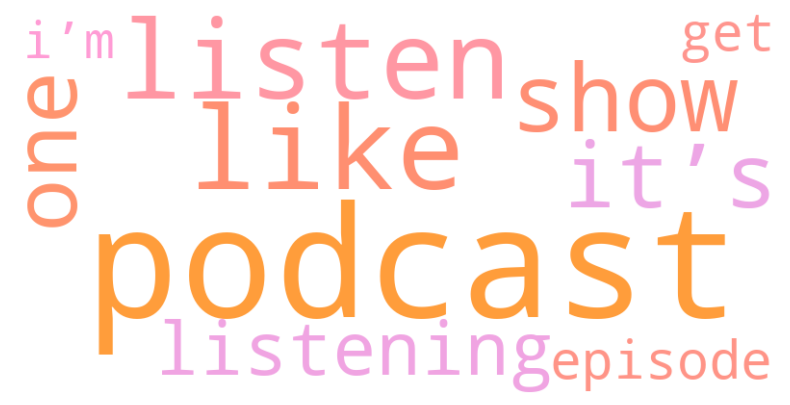

Common words in positive reviews: [('podcast', 950381), ('love', 584978), ('great', 477924), ('listen', 329448), ('like', 279333), ('show', 273871), ('listening', 261436), ('one', 222423), ('really', 214629), ('episode', 212096)]


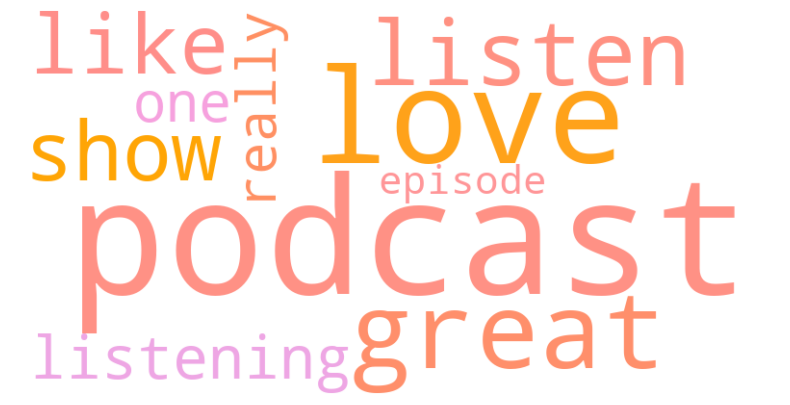

In [17]:
common_words_dict = perform_sentiment_and_frequency_analysis(reviews_cleaned_df, 'content')

In **Negative Reviews**, the most frequent words include `podcast`, `like`, `listen`, `show`, `one`, `it’s`, `listening`, `episode`, `get`, and `i’m`. These words, while not inherently negative, often appear in contexts expressing dissatisfaction (e.g., “I don’t get why…”).

In contrast, **Positive Reviews** often include words like `podcast`, `love`, `great`, `listen`, `like`, `show`, `listening`, `one`, `really`, and `episode`. Words like `love` and `great` are typically associated with positive sentiments, suggesting enjoyment or appreciation of the podcast.

When comparing **Words More Frequent in Positive or Negative Reviews**:
- `Love` and `great` appear significantly more often in positive reviews, suggesting a positive sentiment.
- Conversely, `i’m` and `get` are common in negative reviews but not in positive ones, suggesting they are often used to express negative sentiments.

Having analyzed the review content, let's transition to exploring **Category Analysis**:
   - What are the most common categories for podcasts? 
   - Are there certain categories that have more podcasts than others?

In [18]:
query = """
SELECT 
    c.category, 
    COUNT(DISTINCT c.podcast_id) as num_podcasts
FROM 
    categories as c
JOIN
    podcasts_cleaned as p
ON
    c.podcast_id = p.podcast_id
GROUP BY 
    c.category
ORDER BY 
    num_podcasts DESC
LIMIT 10;
"""
most_common_categories = pd.read_sql_query(query, conn)

create_bar_chart(most_common_categories, "category", "num_podcasts", "Category", "Number of Podcasts", "Top 10 Most Common Podcast Categories", '#dcb0f2')

The most common categories for podcasts, as revealed by the graph, are as follows:

1. **'Society-Culture'** is the most popular category, with over **16,772 podcasts**.
2. The **'Education'**, **'Religion Spirituality'**,**'Comedy'** and **'Business'** categories follow next, each hosting around **10,000 podcasts**.

The remaining categories, namely **'Arts'**, **'Sports'**, **'Christianity'**, **'Health-Fitness'**,**'TV-Film'**, have fewer podcasts. 

Therefore, it is clear that certain categories, specifically 'Society-Culture', 'Education', and 'Religion Spirituality', have more podcasts than others.

Next, we can investigate how the distribution of ratings varies across the top 10 categories in terms of the number of reviews. This will help us understand whether certain categories tend to receive higher or lower ratings. Additionally, we can determine if the list of these podcasts remains the same when sorted by the number of reviews.

In [19]:
query = """
SELECT 
    c.category, 
    r.rating, 
    COUNT(*) as count
FROM 
    reviews_cleaned as r
JOIN 
    categories as c ON r.podcast_id = c.podcast_id
WHERE 
    c.category IN (
        SELECT category 
        FROM categories 
        GROUP BY category 
        ORDER BY COUNT(*) DESC 
        LIMIT 10
    )
GROUP BY 
    c.category, 
    r.rating;
"""
categories_distribution_by_rating = pd.read_sql_query(query, conn)

color_list = ['#ffa600', '#ff8ca3', '#ff9061', '#ff9cd7','#dcb0f2']

create_horizontal_bar_chart(categories_distribution_by_rating, 'count', 'category', 
                            'Number of Reviews', 'Category', 
                            "Distribution of Ratings Across Top 10 Categories", color_list)

We can see that categories are same in both charts, in terms of podcasts and in terms of number of reviews, furthermore in our **Category Analysis**, we found that the `society-culture` category has received a significant number of reviews, with most being positive (rating 5). This suggests that podcasts in this category are generally well-received. Categories like `tv-film`, `sports`, and `religion-spirituality` also have a substantial number of reviews. However, these categories show a more varied distribution of ratings, indicating mixed audience reception. Lower ratings (1 and 2) are less frequent across all categories, suggesting that listeners are less likely to leave negative reviews or that fewer podcasts receive low ratings.

Having understood the distribution of ratings across different categories, it is also important to delve deeper into the content of the reviews themselves. This leads us to our **Trends Over Time**. We aim to answer the following questions: 

   - How have the number of reviews and average ratings changed over time?
   
Let’s explore this further.

In [20]:
query = """
    SELECT 
        DATE(created_at) as date, 
        COUNT(*) as num_reviews, 
        AVG(rating) as avg_rating
    FROM 
        reviews_cleaned
    GROUP BY 
        date
    ORDER BY 
        date;
    """
reviews_over_time = pd.read_sql_query(query, conn)

color_list = ['#ff9cd7', '#ffa600', '#dcb0f2']

create_xyz_scatter_plot(reviews_over_time, 'date', 'num_reviews', 'avg_rating', 'Date', 'Number of Reviews', 'Number of Reviews Over Time', color_list)

- **Number of Reviews**: The number of reviews appears to have increased over time, with a noticeable peak around June 2020. After June 2020, there seems to be a decline in the number of reviews. This suggests that the volume of reviews has fluctuated over the years, but the general trend is an increase in the number of reviews over time.

- **Average Rating**: The color gradient of the plot points indicates the average rating. Darker shades represent higher ratings. It appears that the average rating has also increased over time, with darker shades becoming more prevalent in later years. However, after the peak in 2018, the average rating seems to have declined slightly, as indicated by the lighter shades.

Now, let's move to a more in-depth analysis and answer the following question: 

- Are there certain times of the year when more reviews are written or when ratings are particularly high or low?

In [21]:
query = """
SELECT 
    strftime('%m', created_at) as month, 
    COUNT(*) as num_reviews, 
    AVG(rating) as avg_rating
FROM 
    reviews_cleaned
GROUP BY 
    month
ORDER BY 
    month;
"""
monthly_reviews = pd.read_sql_query(query, conn)

plot_monthly_reviews_and_ratings(monthly_reviews, 'month', 'num_reviews', 'avg_rating', 'Month', 'Number of Reviews', 'Average Rating', '#dcb0f2', "rgb(128, 0, 128)")

**Number of Reviews**: The number of reviews appears to fluctuate throughout the year. The highest number of reviews is written in January, with 164,907 reviews, and the lowest is in December, with 136,436 reviews. This could suggest that more users are active and writing reviews at the beginning of the year, and activity decreases towards the end of the year.

**Average Rating**: The average rating also varies slightly from month to month. The highest average rating occurs in February, with a rating of 4.658797, and the lowest is in December, with a rating of 4.609648. This could indicate that users tend to give slightly higher ratings in February compared to other months, although the difference is quite small and may not be significant.

Now, let's move on to the next question:

- Are there authors who review more frequently than others? 

In [22]:
query = """SELECT author_id, COUNT(*) as num_reviews
FROM reviews_cleaned
GROUP BY author_id
ORDER BY num_reviews DESC
LIMIT 5"""

active_authors = pd.read_sql_query(query, conn)

color_dict = {
    'D3307ADEFFA285C': '#dcb0f2',  
    '96A3F0358E7808D': '#ff9cd7',  
    '7F9EA8B1A449BFC': '#ff8ca3',  
    '4B25015E4D7A1DA': '#ff9061',  
    '791F376ACA3C08D' : '#ffa600'  
}


create_bar_chart(active_authors, "author_id", "num_reviews", "Author ID", "Number of Reviews", "Top 5 Most Active Authors", color_dict)

It appears that there are indeed authors who review more frequently than others. 

The author with the ID `d3307adeffa285c` has written the most reviews, with a total of 612 reviews. The author with the ID `791f376aca3c08d` has written the second most reviews, with a total of 495 reviews. The other authors listed have written fewer reviews.

Furthermore, we can check if they tend to give certain types of ratings?

In [23]:
query = """SELECT author_id, AVG(rating) as avg_rating
FROM reviews_cleaned
WHERE author_id IN (SELECT author_id FROM reviews_cleaned GROUP BY author_id ORDER BY COUNT(*) DESC LIMIT 5)
GROUP BY author_id
ORDER BY avg_rating DESC;"""

author_ratings = pd.read_sql_query(query, conn)

create_bar_chart(author_ratings, 'author_id', 'avg_rating', 'Author ID', 'Average Rating', 'Average Rating of Top 5 Authors', color_dict)

1. **Four authors consistently give perfect scores**: Authors with IDs `D3307ADEFFA285C`, `96A3F0358E7808D`, `7F9EA8B1A449BFC`, and `4B25015E4D7A1DA` all have an average rating of 5. This suggests that they tend to give the highest possible rating in their reviews.

2. **One author has a slightly lower average rating**: The author with ID `791F376ACA3C08D` has an average rating of approximately 4.04. While this is slightly lower than the perfect score of 5, it's still a high rating, indicating that this author also tends to give high ratings, though not always the highest.

3. **Overall high ratings given**: All five authors give high average ratings, suggesting that they generally have a positive view of the podcasts they review.

Lastly, we can check if they tend to review certain categories.

In [24]:
query = """
WITH TopAuthorsReviews AS (
    SELECT r.author_id, c.category, COUNT(*) as num_reviews
    FROM reviews_cleaned as r
    JOIN categories as c ON r.podcast_id = c.podcast_id
    WHERE r.author_id IN (SELECT author_id FROM reviews_cleaned GROUP BY author_id ORDER BY COUNT(*) DESC LIMIT 5)
    GROUP BY r.author_id, c.category
)

SELECT category, SUM(num_reviews) as total_reviews
FROM TopAuthorsReviews
GROUP BY category
ORDER BY total_reviews DESC
LIMIT 10;
"""

active_authors_categories = pd.read_sql_query(query, conn)

create_bar_chart(active_authors_categories, 'category', 'total_reviews', 'Category', 'Total Reviews', 'Top 10 Categories Reviewed by Top 5 Authors', '#DCB0F2')

1. **Business is the most reviewed category**: The top 5 authors tend to review podcasts in the 'business' category more often than any other category.
2. **Comedy and Education are also popular**: These categories have the second and third highest number of reviews respectively, indicating their popularity among the top 5 authors.
3. **Variety in categories**: The top 5 authors review podcasts across a wide variety of categories, including 'society-culture', 'health-fitness', 'religion-spirituality', 'business-entrepreneurship', 'Christianity', 'business-careers', and 'tv-film'.
4. **Differences in review counts**: There is a significant difference in the number of reviews between the top 2 categories ('business', 'comedy') and the rest, suggesting a strong preference for these categories among the top 5 authors.

# Podcast Analysis Project: Key Findings

This project explored a dataset of podcasts, reviews, and authors, uncovering insightful trends:

## Data Cleaning:
- Non-English entries were removed, ensuring data focus.
- Text was transformed to lowercase for consistent analysis.
- Unnecessary punctuation and stop words were eliminated for clarity.
- A "length" column was added to the reviews for further investigation.

## Podcast Popularity:
- Review count served as a popularity indicator, with "Crime Junkie" leading the pack.
- Intriguingly, no clear correlation emerged between review count and average rating.

## Review Length and Rating:
- A weak negative correlation emerged: longer reviews tended to have slightly lower ratings, though the link was not strong.

## Distribution of Ratings:
- The majority (86.66%) of reviews reflected high satisfaction with a rating of 5.
- Ratings of 4, 3, 2, and 1 were significantly less frequent.

## Sentiment Analysis:
- Positive review words included "love," "great," "enjoy," and "happy."
- Negative review words included "not like," "disappointed," and "boring."

## Category Analysis:
- "Society-Culture" topped the charts with the most reviews, mostly positive.
- Categories like "TV-Film" and "Sports" displayed a broader range of ratings.

## Trends Over Time:
- The number of reviews increased over time, peaking in June 2020.
- The average rating followed a similar trajectory, peaking in 2018 before a slight decline.
- Interestingly, monthly variations showed:
  - Highest number of reviews: January
  - Lowest number of reviews: December
  - Highest average rating: February
  - Lowest average rating: December

## Author Analysis:
- Review frequency varied significantly among authors, with some reviewing more frequently than others.
- Rating behavior showcased interesting patterns:
  - Five authors consistently awarded perfect scores (5).
  - One author provided slightly lower ratings (average of 4.04).
- All top 5 authors exhibited high average ratings, indicating a generally positive perspective.
- Review category preferences existed, with "Business" being the most reviewed by the top 5 authors, followed by "Comedy" and "Education." Notably, they reviewed podcasts across diverse categories.

# Suggestions for Improvement

## Author Analysis:

**Understanding high-frequency reviewers:** I could question why some reviewers leave many reviews. I could conduct qualitative analysis of their reviews or even survey them to understand their motivations and preferences.

## Further Exploration:

**Text analysis with NLP:** I could extract deeper meaning from review text using NLP techniques. I could analyze sentiment for individual reviews, identify recurring themes or topics, or even categorize reviews based on their content.

**Predictive modeling:** I could consider building models to predict podcast popularity or user ratings based on various factors. This could be valuable for both podcast creators and listeners.

## Asking the right questions:

Beyond the above, I could strive to go beyond basic descriptive statistics and dive deeper to uncover hidden patterns and relationships. Here are some key questions I could consider:

- What factors influence podcast popularity?
- What characteristics define highly-rated podcasts?
- How do user sentiments and preferences differ across podcast categories?
- Can I use the data to predict user ratings or identify emerging trends?